In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# === SET YOUR DATA PATH ===
data_path = "/kaggle/input/audio-files/wavs"   # 👈 change this
file_ext = ".wav"                              # ".flac" if needed

# === LOAD FILES ===
file_paths = glob.glob(os.path.join(data_path, f"**/*{file_ext}"), recursive=True)
print("Total audio files found:", len(file_paths))

# pick a sample
sample_file_index = 0
SAMPLE_FILE_PATH = file_paths[sample_file_index]
print("Using sample:", SAMPLE_FILE_PATH)

# === LOAD SAMPLE AUDIO ===
wav, sr = librosa.load(SAMPLE_FILE_PATH, sr=None)  # keep original sample rate
print("Duration (s):", len(wav)/sr)
ipd.Audio(wav, rate=sr)


Total audio files found: 6386
Using sample: /kaggle/input/audio-files/wavs/sinh_2067.wav
Duration (s): 5.457142857142857


Mel stats -> Max: 0.0  Min: -69.12332  Mean: -37.36433


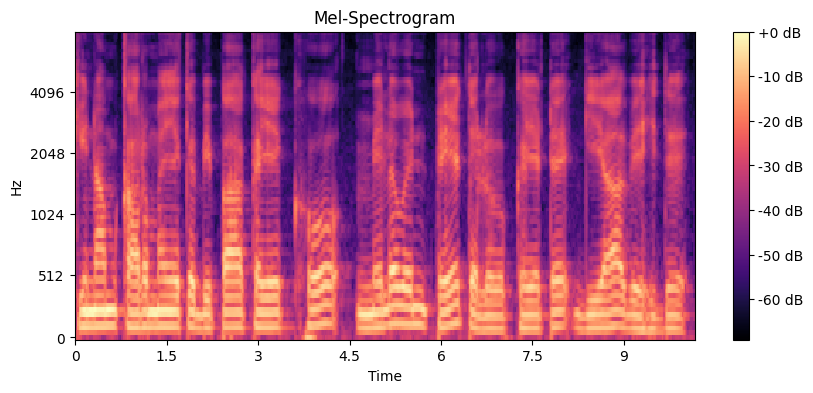

In [ ]:
# Mel spectrogram
mel = librosa.feature.melspectrogram(
    y=wav, sr=sr, n_fft=2400, hop_length=int(sr*0.0125), win_length=int(sr*0.05),
    n_mels=80, fmin=0.0, fmax=8000, power=1.5
)
mel_db = librosa.power_to_db(mel, ref=np.max)

print("Mel stats -> Max:", mel_db.max(), " Min:", mel_db.min(), " Mean:", mel_db.mean())

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram")
plt.show()

# Reconstruct audio with Griffin-Lim
wav_mel = librosa.feature.inverse.mel_to_audio(
    mel, sr=sr, n_fft=2400, hop_length=int(sr*0.0125), win_length=int(sr*0.05),
    power=1.5, n_iter=60
)
ipd.Audio(wav_mel, rate=sr)


Spec stats -> Max: 0.0  Min: -80.0  Mean: -65.47538


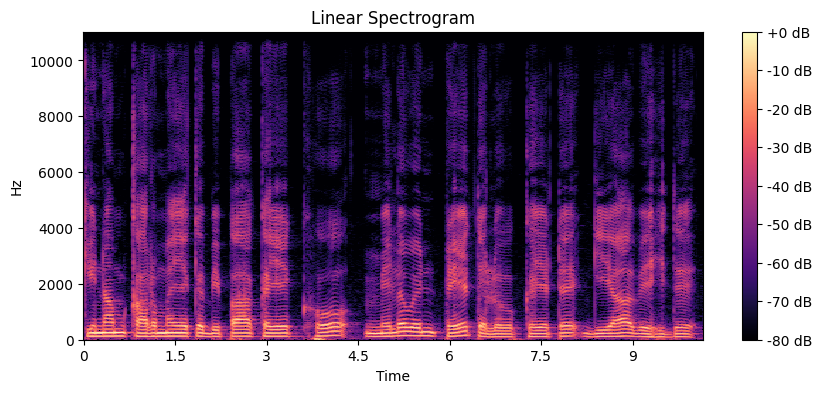

In [3]:
# STFT
spec = librosa.stft(wav, n_fft=2400, hop_length=int(sr*0.0125), win_length=int(sr*0.05))
spec_mag, _ = librosa.magphase(spec)
spec_db = librosa.amplitude_to_db(spec_mag, ref=np.max)

print("Spec stats -> Max:", spec_db.max(), " Min:", spec_db.min(), " Mean:", spec_db.mean())

plt.figure(figsize=(10,4))
librosa.display.specshow(spec_db, sr=sr, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.title("Linear Spectrogram")
plt.show()

# Reconstruct audio with Griffin-Lim
wav_spec = librosa.griffinlim(spec_mag, hop_length=int(sr*0.0125), win_length=int(sr*0.05))
ipd.Audio(wav_spec, rate=sr)


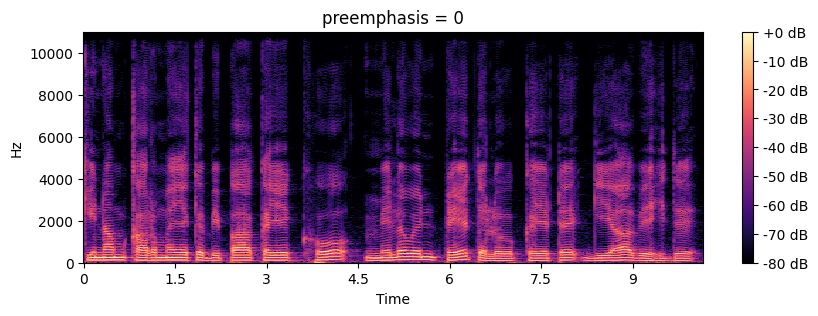

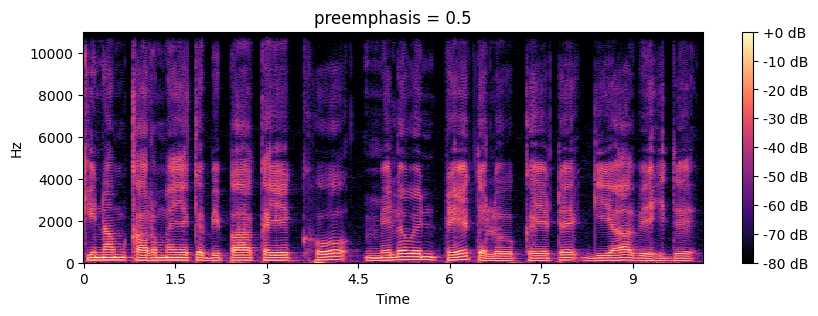

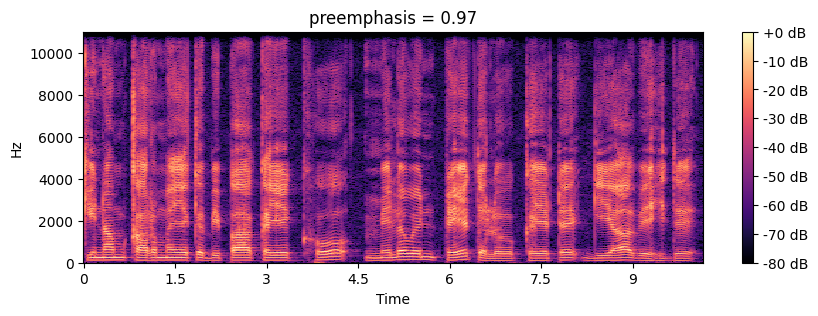

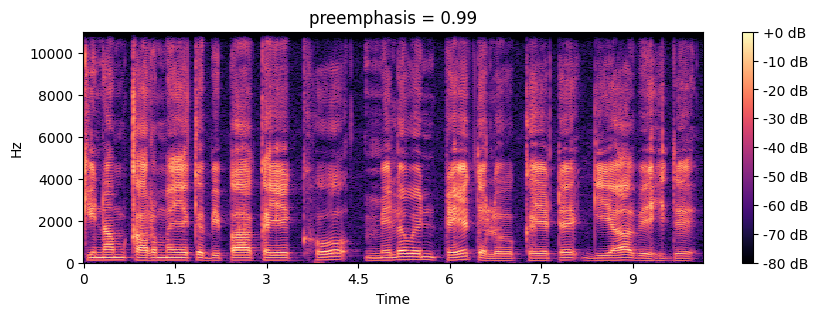

 > Ground-truth audio


 > preemphasis = 0


 > preemphasis = 0.5


 > preemphasis = 0.97


 > preemphasis = 0.99


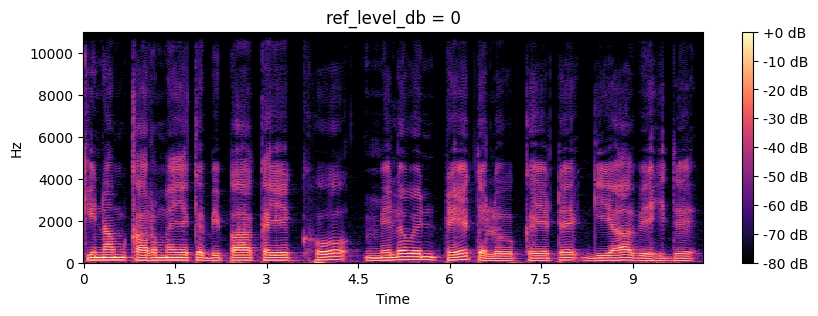

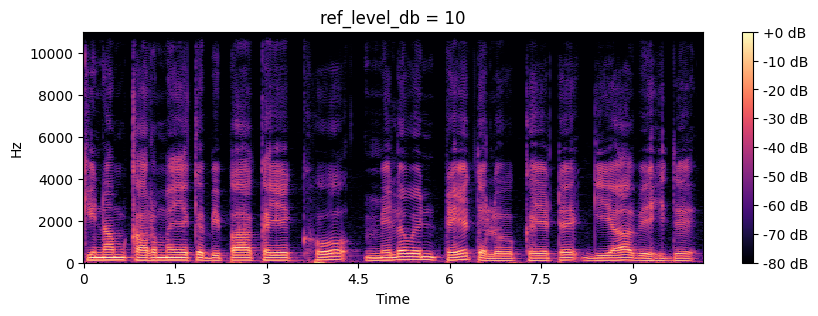

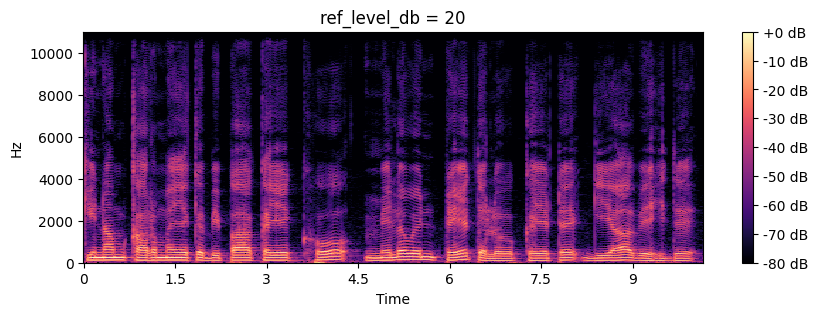

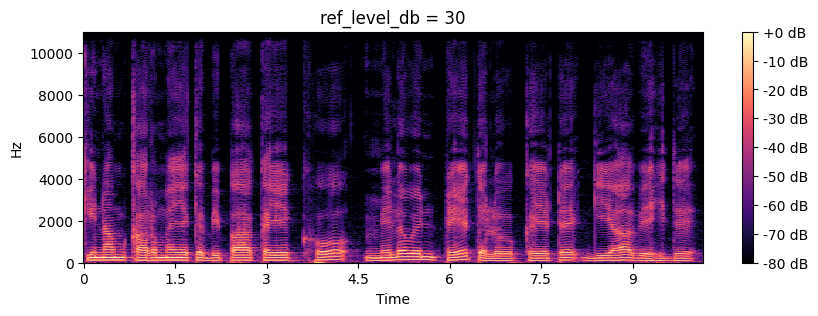

 > Ground-truth audio


 > ref_level_db = 0


 > ref_level_db = 10


 > ref_level_db = 20


 > ref_level_db = 30


In [4]:
def preemphasis_filter(x, coef=0.97):
    """Simple preemphasis filter."""
    return np.append(x[0], x[1:] - coef * x[:-1])

def compare_values(attribute, values):
    wavs = []
    for val in values:
        if attribute == "preemphasis":
            proc_wav = preemphasis_filter(wav, coef=val)
        elif attribute == "ref_level_db":
            # shift dB scale
            proc_wav = wav / np.max(np.abs(wav)) * (10**(val/20))
        else:
            proc_wav = wav
        
        spec = librosa.stft(proc_wav, n_fft=2400, hop_length=int(sr*0.0125), win_length=int(sr*0.05))
        spec_mag, _ = librosa.magphase(spec)
        spec_db = librosa.amplitude_to_db(spec_mag, ref=np.max)

        plt.figure(figsize=(10,3))
        librosa.display.specshow(spec_db, sr=sr, x_axis="time", y_axis="linear")
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"{attribute} = {val}")
        plt.show()

        wav_rec = librosa.griffinlim(spec_mag, hop_length=int(sr*0.0125), win_length=int(sr*0.05))
        wavs.append((val, wav_rec))
    
    print(" > Ground-truth audio")
    ipd.display(ipd.Audio(wav, rate=sr))

    for val, wav_rec in wavs:
        print(f" > {attribute} = {val}")
        ipd.display(ipd.Audio(wav_rec, rate=sr))

# Example usage:
compare_values("preemphasis", [0, 0.5, 0.97, 0.99])
compare_values("ref_level_db", [0, 10, 20, 30])
